In [7]:
# Cell 1 – imports & common paths
import json, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
import optuna

ROOT     = Path("..").resolve()                     # repo root
FIG_DIR  = ROOT / "reports" / "plots" / "finetune"
HPAR_DIR = ROOT / "artifacts" / "hparams"
ARTM_DIR = ROOT / "artifacts" / "models"
FIG_DIR.mkdir(parents=True, exist_ok=True)
print("Figures saved to:", FIG_DIR)


Figures saved to: /teamspace/studios/this_studio/AI_TimeSeries_Forecasting/reports/plots/finetune


In [8]:
# Cell 2 – recreate Optuna study from *.db or .jsonlog (assumes in-memory)
study = optuna.study.load_study(
    study_name="resid_lstm_study",
    storage=f"sqlite:///{HPAR_DIR/'optuna_resid_lstm.db'}"
)
print("Trials completed:", len(study.trials))
best = study.best_params
print("Best params:", best)

# save best params in human-readable form
with open(HPAR_DIR/"best_resid_lstm.json") as f:
    print(json.load(f))


Trials completed: 31
Best params: {'seq_len': 14, 'hidden': 96, 'dropout': 0.017631544582637992, 'lr': 0.0001190696835088992}
{'seq_len': 14, 'hidden': 96, 'dropout': 0.017631544582637992, 'lr': 0.0001190696835088992}


/tmp/ipykernel_159444/644300455.py:9: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  ax = optuna.visualization.matplotlib.plot_param_importances(study)


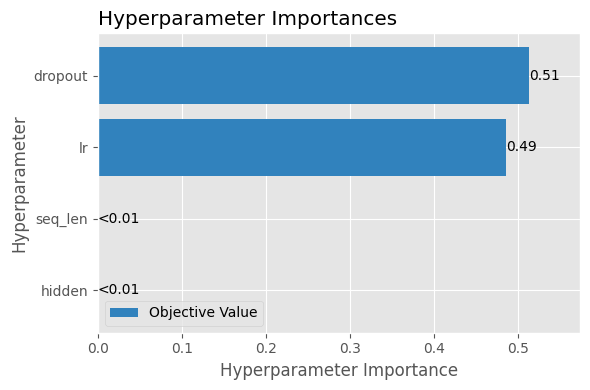

In [14]:
# helper: set size whether obj is Figure or Axes
def set_fig_size(obj, w, h):
    if hasattr(obj, "set_size_inches"):          # Figure
        obj.set_size_inches(w, h)
    elif hasattr(obj, "figure"):                 # Axes
        obj.figure.set_size_inches(w, h)

# Cell 3 – parameter importance
ax = optuna.visualization.matplotlib.plot_param_importances(study)
set_fig_size(ax, 6, 4)
plt.tight_layout()
plt.savefig(FIG_DIR / "param_importance.png", dpi=300)
plt.show()



/tmp/ipykernel_159444/1261251021.py:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  ax_pc = optuna.visualization.matplotlib.plot_parallel_coordinate(


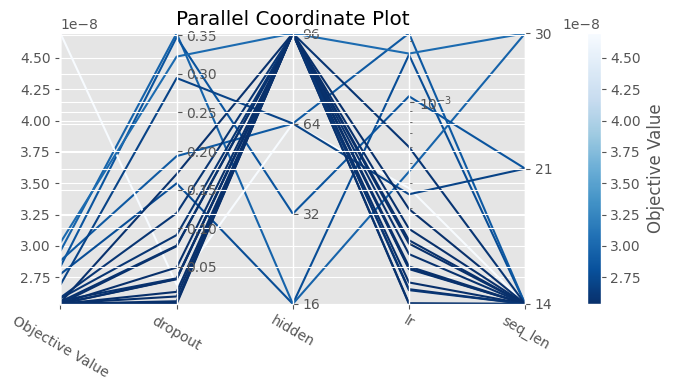

/tmp/ipykernel_159444/1261251021.py:11: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  ax_ct = optuna.visualization.matplotlib.plot_contour(


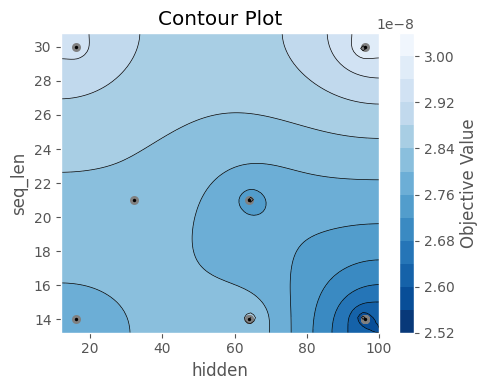

In [15]:
# Cell 4 – Parallel coordinate
ax_pc = optuna.visualization.matplotlib.plot_parallel_coordinate(
    study, params=["seq_len", "hidden", "dropout", "lr"]
)
set_fig_size(ax_pc, 7, 4)     # <- works for Axes or Figure
plt.tight_layout()
plt.savefig(FIG_DIR / "parallel_coord.png", dpi=300)
plt.show()

# Cell 4b – 2-D contour (seq_len × hidden)
ax_ct = optuna.visualization.matplotlib.plot_contour(
    study, params=["seq_len", "hidden"]
)
set_fig_size(ax_ct, 5, 4)
plt.tight_layout()
plt.savefig(FIG_DIR / "contour_seq_hidden.png", dpi=300)
plt.show()


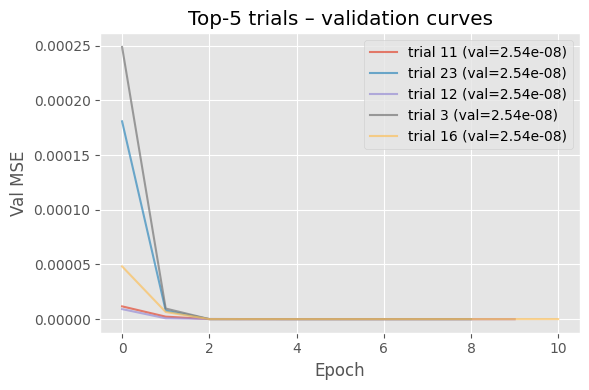

In [16]:
# Cell 5 – Learning curves for top-k successful trials
valid_trials = [t for t in study.trials if t.value is not None]
if len(valid_trials) == 0:
    print("No completed trials with a numeric value – skipping curve plot.")
else:
    topk = sorted(valid_trials, key=lambda t: t.value)[:5]

    plt.figure(figsize=(6,4))
    for t in topk:
        curve = t.user_attrs.get("val_curve")          # list or None
        if curve:
            plt.plot(curve, label=f"trial {t.number} (val={t.value:.2e})", alpha=.7)

    if plt.gca().has_data():
        plt.xlabel("Epoch"); plt.ylabel("Val MSE")
        plt.title("Top-5 trials – validation curves")
        plt.legend()
        plt.tight_layout()
        plt.savefig(FIG_DIR / "top_trials_curves.png", dpi=300)
        plt.show()
    else:
        print("No val_curve stored in the top trials – curve plot skipped.")


,Default,Optuna
MAE,0.000834,0.000901
RMSE,0.000862,0.000928
MAPE,370727.883581,399417.158278


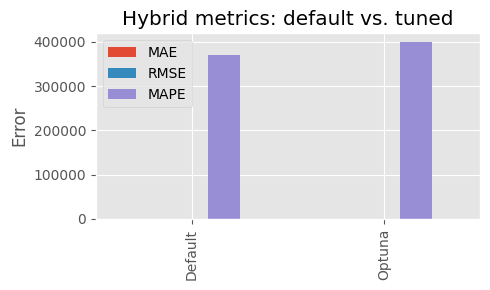

In [17]:
# Cell 6 – Load metrics CSVs
hybrid_def = pd.read_csv(ROOT/"artifacts/metrics/hybrid_metrics.csv")
hybrid_opt = pd.read_csv(ROOT/"artifacts/metrics/hybrid_metrics_optuna.csv")  # write this after retrain

df = pd.concat({"Default":hybrid_def.iloc[0], "Optuna":hybrid_opt.iloc[0]}, axis=1)
display(df)

df.T.plot(kind="bar", figsize=(5,3))
plt.ylabel("Error")
plt.title("Hybrid metrics: default vs. tuned")
plt.tight_layout()
plt.savefig(FIG_DIR/"metrics_comparison.png", dpi=300)
plt.show()


In [18]:
# Cell 7 – summary text
print("Finetuning analysis done.\nPlots in", FIG_DIR, 
      "\nBest params JSON:", HPAR_DIR/"best_resid_lstm.json")


Finetuning analysis done.
Plots in /teamspace/studios/this_studio/AI_TimeSeries_Forecasting/reports/plots/finetune 
Best params JSON: /teamspace/studios/this_studio/AI_TimeSeries_Forecasting/artifacts/hparams/best_resid_lstm.json
